In [0]:
from __future__ import division
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from numpy import array
import sklearn
import torch
import random
from sklearn.datasets import make_classification
import torch.optim as optim
from functools import reduce
import torch.nn.functional as F

# set random seed
# We need to set the cudnn to derministic mode so that 
#we can get consistent result
random_state = 100
np.random.seed(random_state)
torch.manual_seed(random_state)
random.seed(random_state)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('using device ' + str(device))

using device cpu


In [0]:
def z_score(trace_mat, trial_num = 30):
    z_score_trace_mat = np.zeros_like(trace_mat)
    for i in range(trial_num):
        mean_trial = np.mean(trace_mat[i,:])
        std_trial = np.std(trace_mat[i,:])
        z_score_trace_mat[i,:] = (trace_mat[i,:] - mean_trial)/(std_trial)
    return z_score_trace_mat 

In [0]:
def iemg(trace_mat, time_len = 3000, trial_num = 30, winsize = 20, wininc = 6):
    """
    Integrated EMG
    """
    num_win = np.floor((time_len - winsize)/wininc)+1
    iemg_mat = np.zeros([trial_num, int(num_win)])
    st = 0
    en = winsize
    for i in range(int(num_win)):
        iemg_mat[:,i] = np.mean(np.abs(trace_mat[:,st:en]), axis = 1)
        st = st+wininc
        en = en+wininc
    return iemg_mat  

In [0]:
def zc(trace_mat, time_len = 3000, trial_num = 30, winsize = 20, wininc = 6):
    """
    Zero-crossing
    """
    num_win = np.floor((time_len - winsize)/wininc)+1
    zc_mat = np.zeros([trial_num, int(num_win)])
    st = 0
    en = winsize
    for i in range(int(num_win)):
        mat_1 = trace_mat[:,st:en-1]
        mat_2 = trace_mat[:,st+1:en]
        zc_mat[:,i] = np.sum(np.multiply(np.sign(mat_1),np.sign(mat_2)) < 0, axis = 1)
        st = st+wininc
        en = en+wininc
    return zc_mat 

In [0]:
def wl(trace_mat, time_len = 3000, trial_num = 30, winsize = 20, wininc = 6):
    """
    Waveform length
    """
    num_win = np.floor((time_len - winsize)/wininc)+1
    wl_mat = np.zeros([trial_num, int(num_win)])
    st = 0
    en = winsize
    for i in range(int(num_win)):
        mat_1 = trace_mat[:,st:en-1]
        mat_2 = trace_mat[:,st+1:en]
        wl_mat[:,i] = np.sum(np.abs(mat_2 - mat_1), axis = 1)
        #import pdb; pdb.set_trace()
        st = st+wininc
        en = en+wininc
    return wl_mat 

In [0]:
def wamp(trace_mat, time_len = 3000, trial_num = 30, winsize = 20, wininc = 6, threshold = 1):
    """
    Willison Amplitude
    """
    num_win = np.floor((time_len - winsize)/wininc)+1
    wamp_mat = np.zeros([trial_num, int(num_win)])
    st = 0
    en = winsize
    for i in range(int(num_win)):
        mat_1 = trace_mat[:,st:en-1]
        mat_2 = trace_mat[:,st+1:en]
        wamp_mat[:,i] = np.sum(np.abs(mat_2 - mat_1)>threshold, axis = 1)
        st = st+wininc
        en = en+wininc
    return wamp_mat 

In [0]:
def ssc(trace_mat, time_len = 3000, trial_num = 30, winsize = 20, wininc = 6):
    """
    Slope Sign Changes
    """
    num_win = np.floor((time_len - winsize)/wininc)+1
    ssc_mat = np.zeros([trial_num, int(num_win)])
    st = 0
    en = winsize
    for i in range(int(num_win)):
        mat_1 = trace_mat[:,st:en-2]
        mat_2 = trace_mat[:,st+1:en-1]
        mat_3 = trace_mat[:,st+2:en]
        sub_1 = mat_2 - mat_1
        sub_2 = mat_3 - mat_2
        ssc_mat[:,i] = np.sum(np.multiply(np.sign(sub_1),np.sign(sub_2)) < 0, axis = 1)
        st = st+wininc
        en = en+wininc
    return ssc_mat 

In [0]:
def var(trace_mat, time_len = 3000, trial_num = 30, winsize = 20, wininc = 6):
    """
    Variances
    """
    num_win = np.floor((time_len - winsize)/wininc)+1
    var_mat = np.zeros([trial_num, int(num_win)])
    st = 0
    en = winsize
    for i in range(int(num_win)):
        var_mat[:,i] = np.sum(trace_mat[:,st:en]**2, axis = 1)/winsize-1
        st = st+wininc
        en = en+wininc
    return var_mat

In [0]:
def skew(trace_mat, time_len = 3000, trial_num = 30, winsize = 20, wininc = 6):
    """
    Skewness
    """
    num_win = np.floor((time_len - winsize)/wininc)+1
    skew_mat = np.zeros([trial_num, int(num_win)])
    st = 0
    en = winsize
    for i in range(int(num_win)):
        mean = np.mean(trace_mat[:,st:en])
        std = np.std(trace_mat[:,st:en])
        skew_mat[:,i] = np.mean(((trace_mat[:,st:en] - mean)/std)**3, axis = 1)
        st = st+wininc
        en = en+wininc
    return skew_mat 

In [0]:
def kt(trace_mat, time_len = 3000, trial_num = 30, winsize = 20, wininc = 6):
    """
    Kurtosis
    """
    num_win = np.floor((time_len - winsize)/wininc)+1
    kt_mat = np.zeros([trial_num, int(num_win)])
    st = 0
    en = winsize
    for i in range(int(num_win)):
        mean = np.mean(trace_mat[:,st:en])
        std = np.std(trace_mat[:,st:en])
        kt_mat[:,i] = np.mean(((trace_mat[:,st:en] - mean)/std)**4, axis = 1)
        st = st+wininc
        en = en+wininc
    return kt_mat 

In [0]:
#loading the original data set and z-scoring it to give equal weight to all trials across both channels

data_dic = sio.loadmat('male_1')

cyl_ch1 = z_score(data_dic['cyl_ch1'])
cyl_ch2 = z_score(data_dic['cyl_ch2'])
hook_ch1 = z_score(data_dic['hook_ch1'])
hook_ch2 = z_score(data_dic['hook_ch2'])
lat_ch1 = z_score(data_dic['lat_ch1'])
lat_ch2 = z_score(data_dic['lat_ch2'])
palm_ch1 = z_score(data_dic['palm_ch1'])
palm_ch2 = z_score(data_dic['palm_ch2'])
spher_ch1 = z_score(data_dic['spher_ch1'])
spher_ch2 = z_score(data_dic['spher_ch2'])
tip_ch1 = z_score(data_dic['tip_ch1'])
tip_ch2 = z_score(data_dic['tip_ch2'])

data_new = [cyl_ch1, cyl_ch2, hook_ch1, hook_ch2, lat_ch1, lat_ch2, palm_ch1, palm_ch2, spher_ch1, spher_ch2, tip_ch1, tip_ch2]

In [0]:
#Following the ref. paper stated in the link, iemg helps determine when the signal begins. 

data_iemg = []
for i in range(len(data_new)):
    iemg_trace = iemg(data_new[i])
    data_iemg.append(iemg_trace)

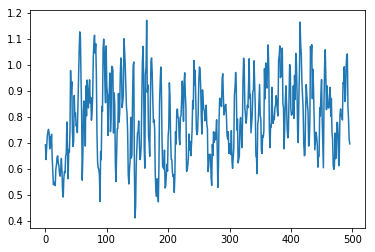

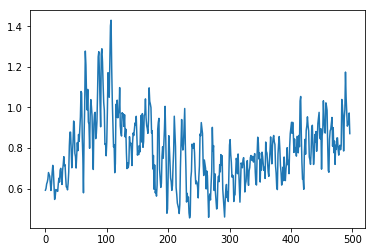

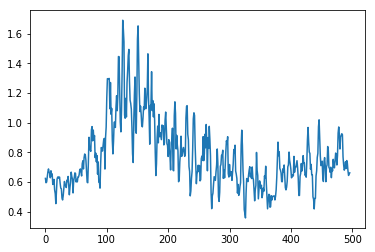

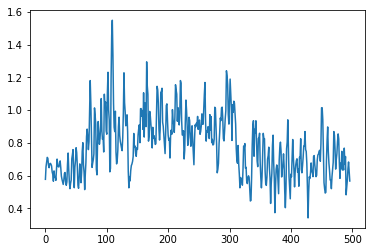

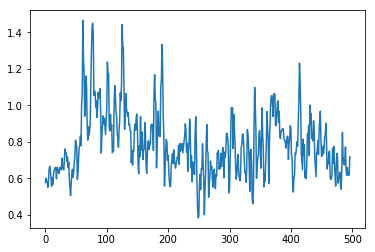

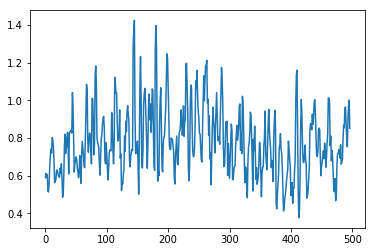

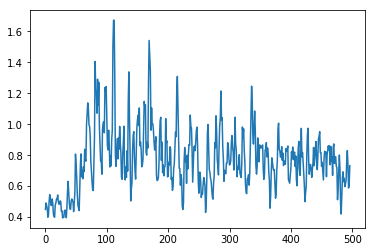

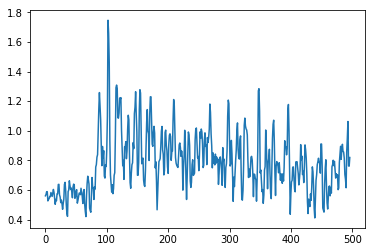

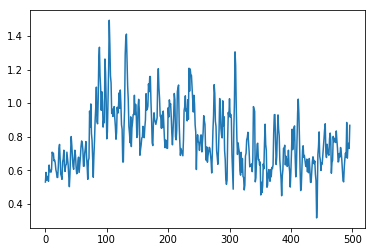

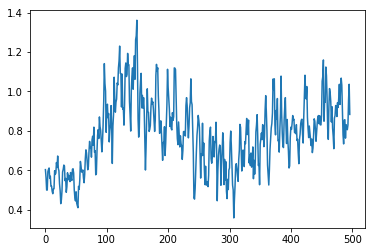

In [0]:
#Assumptions for feature extraction: onset is at 75th sample. This is not true, but there appears to be no consistent onset time.
# This can be fixed by smoothing and thresholding. 

for i in range(10):
    plt.figure()
    plt.plot(data_iemg[8][i,:])

In [0]:
#Currently, using features from the paper. Might include new, but also to be checked which ones contribute most.

data_features = []
for i in range(len(data_new)):
    data_feat = data_new[i][:,75*6:]
    iemg_feat = iemg(data_feat, time_len = 3000-75*6 + 1, winsize = 300, wininc = 30)
    zc_feat = zc(data_feat, time_len = 3000-75*6 + 1, winsize = 300, wininc = 30)
    wl_feat = wl(data_feat, time_len = 3000-75*6 + 1, winsize = 300, wininc = 30)
    wamp_feat = wamp(data_feat, time_len = 3000-75*6 + 1, winsize = 300, wininc = 30, threshold = 1)
    ssc_feat = ssc(data_feat, time_len = 3000-75*6 + 1, winsize = 300, wininc = 30)
    var_feat = var(data_feat, time_len = 3000-75*6 + 1, winsize = 300, wininc = 30)
    skew_feat = skew(data_feat, time_len = 3000-75*6 + 1, winsize = 300, wininc = 30)
    kt_feat = kt(data_feat, time_len = 3000-75*6 + 1, winsize = 300, wininc = 30)

    features = np.concatenate((iemg_feat,zc_feat,wl_feat,wamp_feat,ssc_feat,var_feat,skew_feat,kt_feat),axis = 1)
    data_features.append(features)


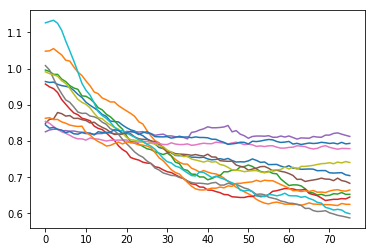

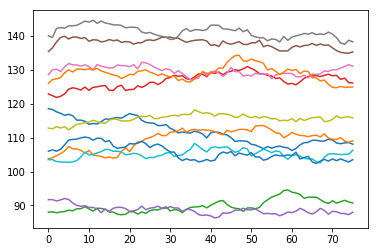

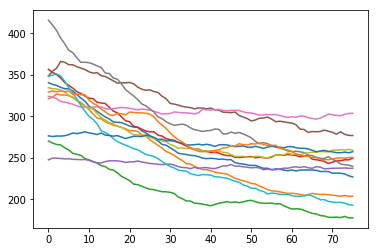

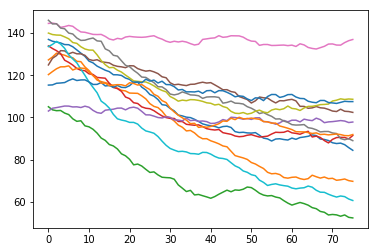

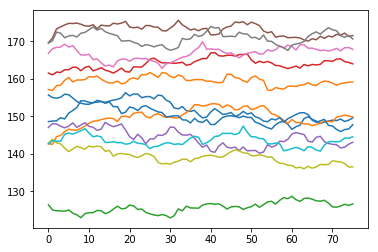

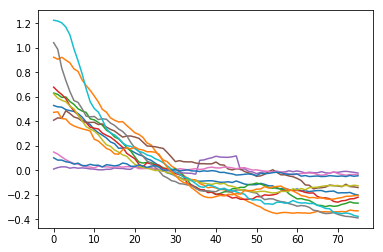

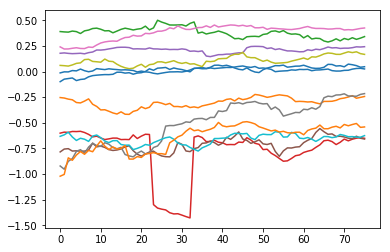

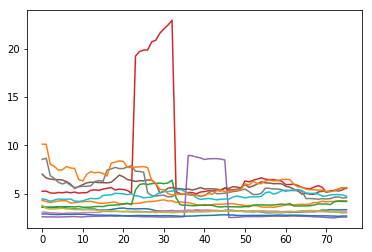

In [0]:
#Plotting various features across all grasps
plt.figure()
for i in range(12):
    plt.plot(np.mean(data_features[i][:,76*0:76*1],axis=0)) 
plt.figure()    
for i in range(12):    
    plt.plot(np.mean(data_features[i][:,76*1:76*2],axis=0)) 
plt.figure()    
for i in range(12):
    plt.plot(np.mean(data_features[i][:,76*2:76*3],axis=0)) 
plt.figure()
for i in range(12):    
    plt.plot(np.mean(data_features[i][:,76*3:76*4],axis=0)) 
plt.figure()
for i in range(12):    
    plt.plot(np.mean(data_features[i][:,76*4:76*5],axis=0))
plt.figure()    
for i in range(12):    
    plt.plot(np.mean(data_features[i][:,76*5:76*6],axis=0)) 
plt.figure()    
for i in range(12):    
    plt.plot(np.mean(data_features[i][:,76*6:76*7],axis=0)) 
plt.figure()    
for i in range(12):    
    plt.plot(np.mean(data_features[i][:,76*7:76*8],axis=0)) 

In [0]:
#Creating train, val and test sets separately for the two channels. The idea is to use pca and possibly a probabilitistic 
#generative model and then take maximum of the two accuracies so we can discriminate between each grasp. 
#train : 60%, val : 20%, test : 20% (Val set is to limit the pca dimensions required for acceptable accuracy)
train_nums = np.random.choice(30,18,replace = False)
train_set_ch1 = np.zeros((18*6,features.shape[1]))
train_set_ch2 = np.zeros_like(train_set_ch1)
val_nums = np.random.choice(np.delete(range(30),train_nums),6, replace =False)
val_set_ch1 = np.zeros((6*6,features.shape[1]))
val_set_ch2 = np.zeros_like(val_set_ch1)
test_nums = np.delete(range(30),np.concatenate((train_nums,val_nums)))
test_set_ch1 = np.zeros((6*6,features.shape[1]))
test_set_ch2 = np.zeros_like(test_set_ch1)

for i in range(6):
    train_set_ch1[18*i:18*(i+1),:] = data_features[i*2][train_nums,:]
    train_set_ch2[18*i:18*(i+1),:] = data_features[i*2+1][train_nums,:]
    val_set_ch1[6*i:6*(i+1),:] = data_features[i*2][val_nums,:]
    val_set_ch2[6*i:6*(i+1),:] = data_features[i*2+1][val_nums,:]
    test_set_ch1[6*i:6*(i+1),:] = data_features[i*2][test_nums,:]
    test_set_ch2[6*i:6*(i+1),:] = data_features[i*2+1][test_nums,:]

Text(0, 0.5, 'Sqrt of eigenvalues')

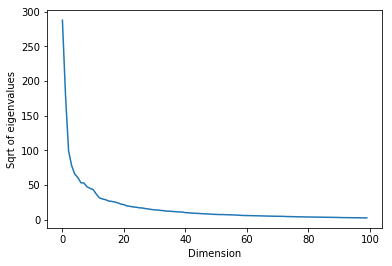

In [0]:
#PCA for channel 1
means = np.mean(train_set_ch1,axis = 1)
ch1_meansub = train_set_ch1 - np.expand_dims(means,axis=1)
sigma = np.cov(np.transpose(ch1_meansub))
w,v = np.linalg.eig(sigma)
eigenvalues = np.sort(w)[::-1]
dimension = np.arange(0,train_set_ch1.shape[1])
plt.plot(dimension[0:100],np.sqrt(np.abs(eigenvalues[0:100])))
plt.xlabel('Dimension')
plt.ylabel('Sqrt of eigenvalues')

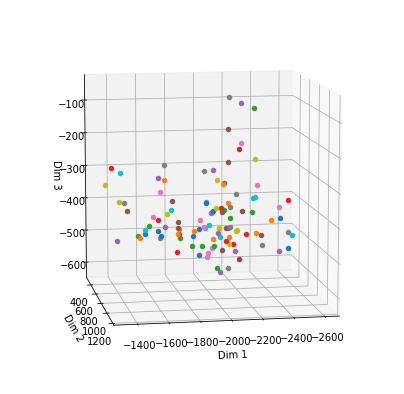

In [0]:
data_proj = ch1_meansub@v[:,0:3].real
data_proj.shape
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
for i in range(data_proj.shape[0]):
    ax.scatter(data_proj[i,0],data_proj[i,1],data_proj[i,2])
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')    
ax.view_init(elev=10, azim=80)

#This doesn't look linearly separable. 

In [0]:
#Looking for examples with the lowest variance in the first two pca directions. The idea is that if a grasp does not have a 
#high variance within a user maybe it can be used as a signature grasp for that user. To check if users can be discriminated 
#using grasps I think the variance of all users with same grasp would be an indicator. 
#It seems like 'hook' is a grasp that could be used. 

print(np.argsort(abs(ch1_meansub@v[:,0])))
print(np.argsort(abs(ch1_meansub@v[:,1])))

[ 34  18  23  28  29  27  35  22  21  19  30  32  26  20   3  24  36  40
   5  37  25  44  47  48  31  41  39  51  11  33  53  45   0  52  10 102
  82  16  50   6  89  96   4   2 106  15   8  97 100  73  49  99  94  91
  84  76  90   9  77  75  14  46  17   1  38  81  80  88  12  83  93 105
  87  98  13  95  42 107 104 101  92  74  85  67  68  65  54 103  58  72
   7  61  86  43  62  69  78  79  66  55  71  56  60  64  70  59  57  63]
[ 37  41  18  85  52  40  98  36  47 103  86  44  12  48  23  45  63  39
  58  42  97  99  33  53  54  49 101  69  35  92  96 100  46 104  11  62
  78  43  93  79  95 106  50 105  68  94  67  55  90  76  51  66  38  84
 102  30  64  71  80  91  29 107  25  24  28  57  32  65  56  74  22  60
  87  27  70  21  26  14  88   6   9  81  19  82   3  89  59  72  61  20
   5   0  16  10   2  13  34  17   1   8  75   7   4  77  83  15  73  31]


In [0]:
#Trying nn since the linear method failed. 
"""
Define the DNN model.
"""
from torch import nn
import torch.nn.functional as F

class DNN(nn.Module):
    def __init__(self,  hidden_dim1, hidden_dim2, hidden_dim3, num_output, input_dim):
        super(DNN, self).__init__()
        
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.num_output = num_output
        
        self.nonlin = nn.ReLU()
        self.dense0 = nn.Linear(in_features = input_dim, out_features = self.hidden_dim1)
        self.dense0_bn = nn.BatchNorm1d(self.hidden_dim1)
        self.dense1 = nn.Linear(in_features = self.hidden_dim1, out_features = self.hidden_dim2)
        self.dense1_bn = nn.BatchNorm1d(self.hidden_dim2)
        self.output = nn.Linear(in_features = self.hidden_dim3, out_features = self.num_output)

    def forward(self, X, **kwargs):
        """
            x: input to the model
                *  x[t] - input of shape (batch, input_size) at time t
                
            hc: hidden and cell states
                *  tuple of hidden and cell state
        """ 
        X = self.dense0(X)
        X_1 = self.nonlin(X)
        X_1 = self.dense0_bn(X_1)
        X_1 = self.dense1(X_1)
        X_2 = self.nonlin(X_1)
        X_2 = self.dense1_bn(X_2)
        #X_3 = self.nonlin(X_2)
        output_seq = self.output(X_2)
        return output_seq    

In [0]:
#Defining the train, val and test sets for nn.

train_X = np.concatenate((train_set_ch1, train_set_ch2),axis = 1)
train_y = np.concatenate((np.zeros((18,1)),np.ones((18,1)),np.ones((18,1))*2,np.ones((18,1))*3,np.ones((18,1))*4,np.ones((18,1))*5),axis=0)
val_X = np.concatenate((val_set_ch1, val_set_ch2),axis = 1)
val_y = np.concatenate((np.zeros((6,1)),np.ones((6,1)),np.ones((6,1))*2,np.ones((6,1))*3,np.ones((6,1))*4,np.ones((6,1))*5),axis=0)
test_X = np.concatenate((test_set_ch1, test_set_ch2),axis = 1)
test_y = np.concatenate((np.zeros((6,1)),np.ones((6,1)),np.ones((6,1))*2,np.ones((6,1))*3,np.ones((6,1))*4,np.ones((6,1))*5),axis=0)

s = np.arange(train_X.shape[0])
np.random.shuffle(s)
train_X = train_X[s,:]
train_y = train_y[s]
s = np.arange(val_X.shape[0])
np.random.shuffle(s)
val_X = val_X[s,:]
val_y = val_y[s]

In [0]:

dnn = DNN(hidden_dim1 = 512, hidden_dim2 = 128, hidden_dim3 = 128, num_output = 6, input_dim = train_X.shape[1])  
dnn = dnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dnn.parameters(), lr=0.001)


In [0]:
def train(dnn, input_tensor, target_tensor):
    
    optimizer.zero_grad()
    
    dnn = dnn.float()
    
    output = dnn(input_tensor.float())
    
    loss = criterion(output, target_tensor.squeeze(1))
    
    # calculate the gradients
    loss.backward()

    # update the parameters of the model
    optimizer.step()

    return output, loss.item()

In [0]:
def evaluate(dnn,input_tensor):
    output = dnn(input_tensor.float())
    return output

In [0]:
#Potential transfer learning to check what layers are generalizable across users.

#dnn = DNN(hidden_dim1 = 512, hidden_dim2 = 128, hidden_dim3 = 128, num_output = 6, input_dim = train_X.shape[1])
#model_save_name = 'classifier.pt'
#path = F"/content/gdrive/My Drive/{model_save_name}"
#dnn = torch.load(path)

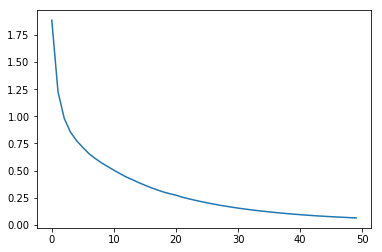

In [0]:
X_train_gpu = torch.tensor(train_X, device=device, requires_grad = True)
y_train_gpu = torch.tensor(train_y, dtype=torch.long, device=device)
  
print_every = 30
all_tr_losses = []
itr = 50
cnt = 0
    
for iter in np.arange(itr):
  #The intention here is to update only selected layers and use transfer learning for the rest. Don't know why this fails, needs more 
  #debugging.
  
    for p in dnn.dense0.parameters():
        p.requires_grad = True
    for p in dnn.dense1.parameters():
        p.requires_grad = True
    for p in dnn.dense0_bn.parameters():
        p.requires_grad = True  
    for p in dnn.dense1_bn.parameters():
        p.requires_grad = True   
    for p in dnn.output.parameters():
        p.requires_grad = True      
    output_tr, loss = train(dnn, X_train_gpu, y_train_gpu)
    all_tr_losses.append(loss)
    cnt += 1 
    
    if cnt % print_every == 0:
        out_proba_val = F.softmax(output_tr, dim = -1)  
        out_proba_val = out_proba_val.cpu().detach().numpy()
        #print(np.argmax(out_proba_val,axis=1))
        #print(input_y)
       
        
plt.plot(all_tr_losses); plt.show()

In [0]:
X_val_gpu = torch.tensor(val_X, device=device, requires_grad = True)
y_val_gpu = torch.tensor(val_y, dtype=torch.long, device=device)

output = evaluate(dnn, X_val_gpu)
out_proba_val = F.softmax(output, dim=-1)  
out_proba_val = out_proba_val.cpu().detach().numpy()
val_preds = np.argmax(out_proba_val,axis=1)

In [0]:
sum(val_preds == np.squeeze(val_y))

34

In [0]:
X_test_gpu = torch.tensor(test_X, device=device, requires_grad = True)
y_test_gpu = torch.tensor(test_y, dtype=torch.long, device=device)

output = evaluate(dnn, X_test_gpu)
out_proba_val = F.softmax(output, dim=-1)  
out_proba_val = out_proba_val.cpu().detach().numpy()
val_preds = np.argmax(out_proba_val,axis=1)

In [0]:
sum(val_preds == np.squeeze(test_y))

30

In [0]:
from sklearn.metrics import confusion_matrix

# calculation the confusion matrix
# row: true label
# col: predicted value
cm = np.array(confusion_matrix(test_y,val_preds))
print('confusion matrix')
print(cm)

confusion matrix
[[6 0 0 0 0 0]
 [0 5 0 0 1 0]
 [0 0 6 0 0 0]
 [0 0 0 5 0 1]
 [2 0 0 0 4 0]
 [0 0 1 1 0 4]]


In [0]:
#model_save_name = 'classifier.pt'
#path = F"/content/gdrive/My Drive/{model_save_name}" 
#torch.save(dnn, path)